In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import circularFiltering as flt
import matplotlib
matplotlib.rcParams.update({'font.size': 14,
                            'pdf.fonttype': 42,
                            'ps.fonttype': 42})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [2]:
####### simulation parameters
np.random.seed(42)
T = 15
dt = 0.01
t = np.arange(0,T,dt)
kappa_phi = 1 # inverse diffusion constant
kappa_v = 2 # precision of relative heading info
kappa_z = 15 # precision of absolute heading info (called gamma_z in manuscript)
alpha = flt.xi_fun_inv(kappa_z*dt) 

### create kappa_z depending on environment. If light is off, kappa_z is zero (maximally uninformative)
kappa_z_array = alpha * np.ones(int(T/dt)) # precision of absolute heading info
t_off = 5
t_on = 10
ind_off = int(t_off/dt)
ind_on = int(t_on/dt)
kappa_z_array[ind_off:ind_on] = 0 # maximally uninformative while light is off

### create hidden state trajectory and observation sequence
phi = np.zeros(int(T/dt)) # latent state
phi_0 = 0 
kappa_0 = 10 # initial certainty
phi[0] = np.random.vonmises(phi_0,kappa_0)
phi[0] = (phi[0] + np.pi ) 
dy = np.zeros(int(T/dt))
for i in range(1,int(T/dt)):
        phi[i] = np.random.normal(phi[i-1],1/np.sqrt(kappa_phi) * np.sqrt(dt))
        dy[i] = np.random.normal(phi[i]-phi[i-1],1/np.sqrt(kappa_v) * np.sqrt(dt))
phi = (phi % (2*np.pi) ) - np.pi
mu_z = np.random.vonmises(phi,kappa_z_array)

In [3]:
############ run circKF (von Mises projection filter)
                
mu_ProF, kappa_ProF = flt.vM_Projection_Run(T,kappa_phi,z=mu_z,kappa_z=kappa_z_array,dy=dy,kappa_y=kappa_v,
                        phi_0=phi_0,kappa_0=kappa_0,dt=dt)

In [4]:
############ Single population network
N = 80
phi_0_r = np.linspace(-np.pi,np.pi-(2*np.pi)/N,N)
alpha = 100


##### connectivity matrices
W_rec_even = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        W_rec_even[i,j] = 2/N * np.cos(phi_0_r[i] - phi_0_r[j])
        
W_rec_odd = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        W_rec_odd[i,j] = 2/N * np.sin(phi_0_r[i] - phi_0_r[j])
        
M_inh = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        M_inh[i,j] =  (2/N)**2 * np.cos(phi_0_r[i] - phi_0_r[j])


# set network parameters to match filtering
alpha_tilde = 0
alpha = alpha_tilde + 1/2 * kappa_v/kappa_phi * 1/(kappa_phi + kappa_v)
W = ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
      + (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[0]/dt )
M =  M_inh

# init
r = np.zeros((int(T/dt),N))
r[0] = kappa_0 * np.cos(phi_0_r - phi_0)

# run network filter
for i in range(1,int(T/dt)):
    W =  ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
      + (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[i]/dt )
    r[i] = (r[i-1] 
            - alpha * r[i-1] * dt # decay
            - 1/(kappa_phi+kappa_v) * np.sqrt(np.dot(r[i-1],np.dot(M,r[i-1]))) * r[i-1] * dt # coincidence detector
            + np.dot(W,r[i-1]) * dt # angular velocity integration
           + kappa_z_array[i]*np.cos(phi_0_r-mu_z[i])) # absolute heading info (external input)
    
# decode stochastic variables
A_cos =  np.array([np.cos(phi_0_r),np.sin(phi_0_r)])
theta = 2/N * A_cos @ r.transpose() # FT in Cartesian domain
kappa_NN = np.sqrt(np.sum(theta**2,0)) #convert to polar coordinates
mu_NN = np.arctan2(theta[1],theta[0])

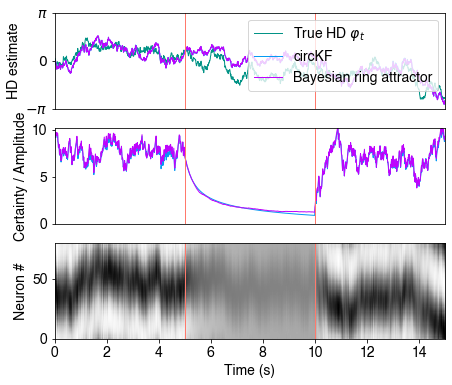

In [5]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(7,6))

ax1.plot(*flt.circplot(t,phi),linewidth=1,label=r'True HD $\varphi_t$',color='xkcd:teal')
ax1.plot(*flt.circplot(t,mu_ProF),linewidth=1,color='xkcd:azure',label='circKF')
ax1.plot(*flt.circplot(t,mu_NN),linewidth=1, label=r'Bayesian ring attractor',color='xkcd:bright purple')
ax1.plot([t_on,t_on],[-np.pi,np.pi],linewidth=1,color='xkcd:salmon')
ax1.plot([t_off,t_off],[-np.pi,np.pi],linewidth=1,color='xkcd:salmon')
ax1.set_xlim([0,T])
ax1.set_ylim([-np.pi,np.pi])
ax1.set_ylabel('HD estimate')
ax1.set_yticks([0., - np.pi, np.pi])
ax1.set_yticklabels(["$0$",r"$-\pi$",r"$\pi$"])
ax1.set_xticks([])
ax1.legend()

ax2.plot(t,kappa_ProF,linewidth=1,label=r'Precision $\kappa_t$',color='xkcd:azure')
ax2.plot(t,kappa_NN,linewidth=1, label=r'Network amplitude $\tilde{r}_1(t)$',color='xkcd:bright purple')
ax2.plot([t_on,t_on],[0,np.max(kappa_ProF)],linewidth=1,color='xkcd:salmon')
ax2.plot([t_off,t_off],[0,np.max(kappa_ProF)],linewidth=1,color='xkcd:salmon')
ax2.set_xlim([0,T])
ax2.set_xticks([])
ax2.set_ylim([0,np.max(kappa_ProF)])
ax2.set_ylabel(r'Certainty / Amplitude')


im = ax3.imshow(r.transpose(), cmap='Greys', interpolation='nearest', extent=[0,T,0,N],aspect='auto',origin='lower')#,vmin=-5,vmax=5)
ax3.plot([t_on,t_on],[0,N],linewidth=1,color='xkcd:salmon')
ax3.plot([t_off,t_off],[0,N],linewidth=1,color='xkcd:salmon')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Neuron #')

plt.show()